In [3]:
import scanpy as sc
# import wandb
# from utils import find_closest_points
import numpy as np
import pandas as pd
# import gensim
# from gensim.models import word2vec
from tqdm import tqdm
from scipy.spatial import cKDTree
from sklearn import model_selection
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
from sklearn.metrics import r2_score
# import nichepca as npc
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read data

In [4]:
# adata_msi_full = sc.read('/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/MSI_concat_neurotransmitters.h5ad')
# adata_rna_full = sc.read('/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/RNA_concat_neurotransmitters.h5ad')
adata_msi_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_neurotransmitters.h5ad')
adata_rna_full = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_neurotransmitters.h5ad')


/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/vitatrack/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/vitatrack/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Subset to slides A1 and B1

In [5]:
adata_msi_full

AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
adata_msi = adata_msi_full[adata_msi_full.obs.slide != "V11L12-109_C1", :].copy()#, adata_msi_full.var.highly_variable].copy()# & adata_rna.obs.highly_variable

In [7]:
adata_msi #slide 3 not included in MSI_concat_neuro

AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Remove m/z below FMP10, because most likely this is noise 

In [8]:
adata_msi_full.var_names

Index(['156.26059', '156.26195', '156.48344', '156.4838', '156.485',
       '157.54681', '158.41217', '160.02547', '170.45622', '170.45738',
       ...
       '1044.29885', '1044.3523', '1046.31366', '1046.32671', '1046.33977',
       '1046.36442', '1048.32025', '1048.3319', '1048.34354', '1048.38431'],
      dtype='object', length=1538)

In [9]:
adata_msi = adata_msi[:, adata_msi.var_names.astype(float) > 288.15].copy()

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/vitatrack/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata_msi

AnnData object with n_obs × n_vars = 5443 × 1361
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

QC

In [11]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

<Axes: xlabel='total_counts', ylabel='Count'>

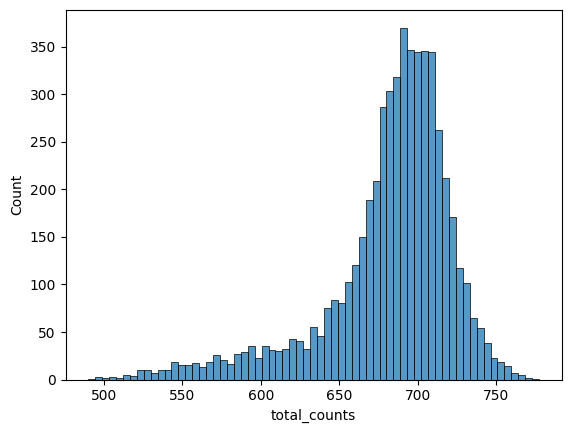

In [12]:
sns.histplot(adata_msi.obs.total_counts)

<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

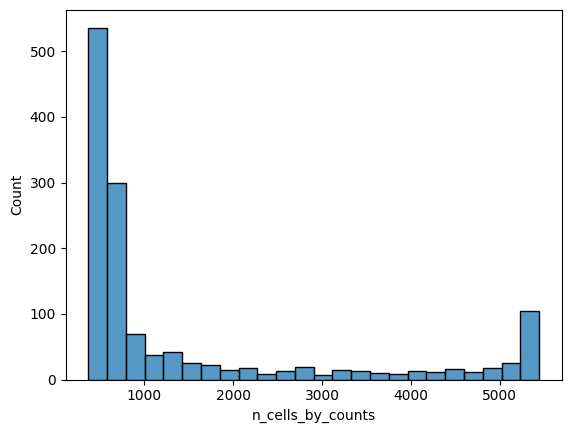

In [13]:
sns.histplot(adata_msi.var.n_cells_by_counts)

In [14]:
adata_msi.var.n_cells_by_counts.describe()

count    1361.000000
mean     1519.506980
std      1639.893486
min       367.000000
25%       510.000000
50%       632.000000
75%      1718.000000
max      5443.000000
Name: n_cells_by_counts, dtype: float64

Removing highly abundant m/z because this is also most likely noise 

In [15]:
sc.pp.filter_genes(adata_msi, max_cells=1750)

/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/vitatrack/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

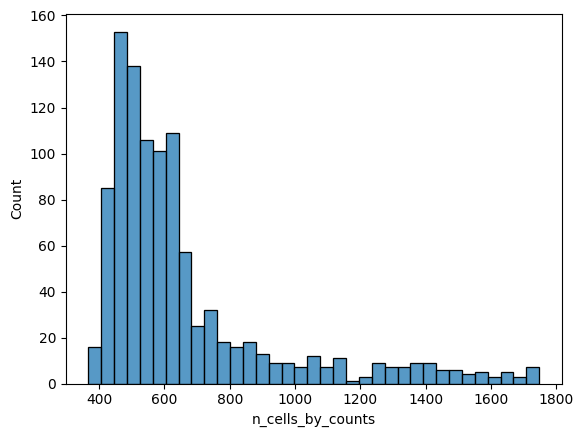

In [16]:
sns.histplot(adata_msi.var.n_cells_by_counts)

<Axes: xlabel='total_counts', ylabel='Count'>

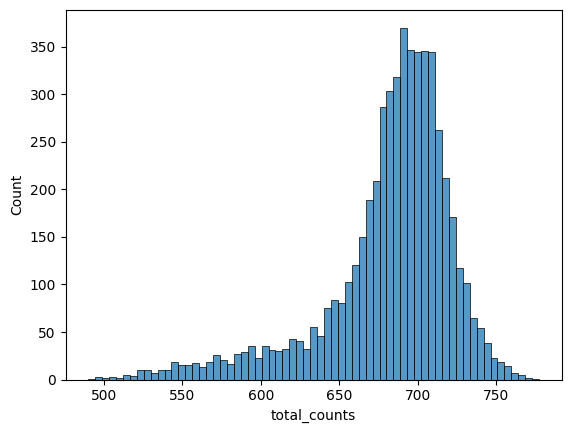

In [17]:
sns.histplot(adata_msi.obs.total_counts)

Read metabolite annotations from the FMP10 paper

In [18]:
names = pd.read_csv("/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/FMP10_metabolite_weights.csv").iloc[:, :2]

In [19]:
names["Observed Mass (m/z) coarse"] = names["Observed Mass (m/z)"].round(1)

In [20]:
m_z = adata_msi.var_names.astype(float).round(1)

Coarsly annotating metabolites

In [21]:
len(set(names["Observed Mass (m/z) coarse"]).intersection(set(m_z)))

new_vars = []
for col in adata_msi.var_names.astype(float).round(1):
    if col in names["Observed Mass (m/z) coarse"].tolist() and names.loc[names["Observed Mass (m/z) coarse"] == col]["Compound"].shape[0] == 1:
        new_vars.append(names.loc[names["Observed Mass (m/z) coarse"] == col]["Compound"].tolist()[0])
    else:
        new_vars.append(str(col))

In [22]:
adata_msi.var_names_new = new_vars

Plotting some of metabolite expressions

In [23]:
# for i, col in enumerate(adata_msi.var_names_new):
#     try:
#         a= float(col)
#         continue
#     except:
#         sns.scatterplot(x=adata_msi[adata_msi.obs.slide == "V11L12-109_A1"].obsm["spatial_warp"][:, 0], 
#                         y=adata_msi[adata_msi.obs.slide == "V11L12-109_A1"].obsm["spatial_warp"][:, 1], 
#                         c=adata_msi[adata_msi.obs.slide == "V11L12-109_A1"].X[:, i].flatten(),
#                        s=15)
#         plt.title(col)
#         plt.show()

In [24]:
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp', )

In [25]:
adata_msi

AnnData object with n_obs × n_vars = 5443 × 1026
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Checking is some m/z are spatially variable after removing noize

In [26]:
sq.gr.spatial_autocorr(adata_msi)

In [27]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_index()

,I,pval_norm,var_norm,pval_norm_fdr_bh
1006.2271,0.022269,1.004602e-03,0.000053,3.036990e-02
400.18521,0.022781,7.905536e-04,0.000053,2.589063e-02
435.20692,0.431915,0.000000e+00,0.000053,0.000000e+00
445.09869,0.023735,4.998920e-04,0.000053,1.785978e-02
569.25386,0.024726,3.052923e-04,0.000053,1.199799e-02
674.2805,0.264561,0.000000e+00,0.000053,0.000000e+00
674.28592,0.396906,0.000000e+00,0.000053,0.000000e+00
674.28833,0.442162,0.000000e+00,0.000053,0.000000e+00
675.28961,0.189879,0.000000e+00,0.000053,0.000000e+00
675.29202,0.325730,0.000000e+00,0.000053,0.000000e+00


In [28]:
adata_msi

AnnData object with n_obs × n_vars = 5443 × 1026
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [29]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.round(1)

Index(['674.28833', '435.20692', '674.28592', '675.29202', '674.2805',
       '675.28961', '858.31325', '805.33878', '843.3189', '569.25386',
       '445.09869', '400.18521', '1006.2271', '682.12245'],
      dtype='object')

In [30]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)

Index([ 674.3,  435.2,  674.3,  675.3,  674.3,  675.3,  858.3,  805.3,  843.3,
        569.3,  445.1,  400.2, 1006.2,  682.1],
      dtype='float64')

In [31]:
inter = list(set(adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)).intersection(set(names["Observed Mass (m/z) coarse"])))

In [32]:
names["Observed Mass (m/z) coarse"].sort_values()

115     356.2
43      357.2
74      371.2
124     373.2
75      379.2
        ...  
0      1122.5
37     1196.4
36     1210.5
35     1224.5
34     1238.5
Name: Observed Mass (m/z) coarse, Length: 141, dtype: float64

In [33]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)

Index([ 674.3,  435.2,  674.3,  675.3,  674.3,  675.3,  858.3,  805.3,  843.3,
        569.3,  445.1,  400.2, 1006.2,  682.1],
      dtype='float64')

In [34]:
set(adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)).intersection(set(names["Observed Mass (m/z) coarse"]))

{435.2}

In [35]:
names["Observed Mass (m/z) coarse"]

0      1122.5
1      1108.4
2       855.4
3       701.3
4       687.3
        ...  
136     658.9
137     385.2
138     480.2
139     478.2
140     466.2
Name: Observed Mass (m/z) coarse, Length: 141, dtype: float64

In [36]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)

Index([ 674.3,  435.2,  674.3,  675.3,  674.3,  675.3,  858.3,  805.3,  843.3,
        569.3,  445.1,  400.2, 1006.2,  682.1],
      dtype='float64')

In [37]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)

Index([ 674.3,  435.2,  674.3,  675.3,  674.3,  675.3,  858.3,  805.3,  843.3,
        569.3,  445.1,  400.2, 1006.2,  682.1],
      dtype='float64')

In [38]:
names["Observed Mass (m/z) coarse"]

0      1122.5
1      1108.4
2       855.4
3       701.3
4       687.3
        ...  
136     658.9
137     385.2
138     480.2
139     478.2
140     466.2
Name: Observed Mass (m/z) coarse, Length: 141, dtype: float64

In [39]:
adata_msi.var_names_new

['289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '290.1',
 '290.1',
 '290.1',
 '290.1',
 '290.1',
 '291.1',
 '294.1',
 '295.1',
 '296.1',
 '296.1',
 '296.1',
 '296.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.2',
 '298.1',
 '298.1',
 '298.1',
 '298.2',
 '299.1',
 '299.1',
 '299.2',
 '300.1',
 '300.1',
 '301.1',
 '301.1',
 '301.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '303.1',
 '303.1',
 '303.1',
 '303.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '305.1',
 '306.1',
 '307.1',
 '308.1',
 '309.1',
 '309.1',
 '310.1',
 '310.1',
 '310.1',
 '310.1',
 '311.1',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '312.1',
 '312.1',
 '312.1',
 '312.2',
 '312.2',
 '313.2',
 '313.2',
 '314.2',
 '316.1',
 '316.2',
 '318.2',
 '320.1',
 '321.1',
 '322.1',
 '323.2',
 '324.1',
 '324.1',
 '324.1',
 '324.2',
 '324.2',
 '325.1',
 '325.2',
 '326.1',


In [40]:
import pandas as pd

# Convert var_names to a DataFrame
df_var_names = pd.DataFrame(adata_msi.var_names, columns=["var_names"])

# Display the DataFrame
df_var_names


,var_names
0,289.11568
1,289.11778
2,289.11933
3,289.11988
4,289.12044
...,...
1021,1046.36442
1022,1048.32025
1023,1048.3319
1024,1048.34354


In [41]:
names.loc[names["Observed Mass (m/z) coarse"].isin(inter)]


,Compound,Observed Mass (m/z),Observed Mass (m/z) coarse
6,3-MT,435.21,435.2


In [42]:
names

,Compound,Observed Mass (m/z),Observed Mass (m/z) coarse
0,[D-Ala2]-Met-enkephalin double,1122.46,1122.5
1,[D-Ala2]-Met-enkephalin double (*),1108.44,1108.4
2,[D-Ala2]-Met-enkephalin single,855.35,855.4
3,3 4-dihydroxyphenylacetone,701.28,701.3
4,3 4-dihydroxyphenylacetone double (*),687.27,687.3
...,...,...,...
136,Tyramine double (*),658.90,658.9
137,Valine single,385.19,385.2
138,Vanillactic acid,480.18,480.2
139,Vanilpyruvate,478.17,478.2
